In [1]:

import pandas as pd
import os
import numpy as np


# root_dir = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))  
root_dir = "/Users/cheryang/Documents/GitProject/RL-IBL-Re"
os.chdir(root_dir)
os.getcwd()

'/Users/cheryang/Documents/GitProject/RL-IBL-Re'

## Load Data

In [2]:
X = pd.read_csv("./data/X.csv", index_col=0) 
Y = pd.read_csv("./data/Y.csv", index_col=0).rename(columns={"x":"y"})
y = np.ravel(Y)

In [3]:
X.shape, y.shape,

((176, 624), (176,))

## Preprocessing

In [4]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np


In [5]:
import numpy as np
from sklearn.utils import resample

def sample_dataset(X, y, sample_method, random_state=None):
    """
    Perform up-sampling, down-sampling, or random shuffling on the dataset.

    Parameters:
    X: array-like, shape (n_samples, n_features)
        The feature matrix.

    y: array-like, shape (n_samples,)
        The target array.

    sample_method: str
        The sampling method to apply: 'upsample', 'downsample', or 'shuffle'.

    random_state: int or None, optional (default=None)
        Random seed for reproducibility.

    Returns:
    X_sampled: array-like, shape (n_samples_sampled, n_features)
        The sampled feature matrix.

    y_sampled: array-like, shape (n_samples_sampled,)
        The sampled target array.
    """
    unique_labels, label_counts = np.unique(y, return_counts=True)
    majority_label = unique_labels[np.argmax(label_counts)]
    minority_label = unique_labels[np.argmin(label_counts)]

    if sample_method == 'upsample':
        X_sampled, y_sampled = upsample_dataset(X, y, majority_label, minority_label, random_state=random_state)
    elif sample_method == 'downsample':
        X_sampled, y_sampled = downsample_dataset(X, y, majority_label, minority_label, random_state=random_state)
    elif sample_method == 'shuffle':
        X_sampled, y_sampled = shuffle_dataset(X, y, random_state=random_state)
    else:
        raise ValueError("Invalid sample_method. Choose 'upsample', 'downsample', or 'shuffle'.")

    return X_sampled, y_sampled

def upsample_dataset(X, y, majority_label, minority_label, random_state=None):
    # Perform up-sampling on the dataset
    X_majority = X[y == majority_label]
    X_minority = X[y == minority_label]

    X_minority_upsampled = resample(X_minority, replace=True, n_samples=X_majority.shape[0], random_state=random_state)
    X_upsampled = np.vstack((X_majority, X_minority_upsampled))

    y_majority = np.full(X_majority.shape[0], fill_value=majority_label)
    y_minority_upsampled = np.full(X_minority_upsampled.shape[0], fill_value=minority_label)
    y_upsampled = np.hstack((y_majority, y_minority_upsampled))

    return X_upsampled, y_upsampled

def downsample_dataset(X, y, majority_label, minority_label, random_state=None):
    # Perform down-sampling on the dataset
    X_majority = X[y == majority_label]
    X_minority = X[y == minority_label]

    X_majority_downsampled = resample(X_majority, replace=False, n_samples=X_minority.shape[0], random_state=random_state)
    X_downsampled = np.vstack((X_majority_downsampled, X_minority))

    y_majority_downsampled = np.full(X_majority_downsampled.shape[0], fill_value=majority_label)
    y_minority = np.full(X_minority.shape[0], fill_value=minority_label)
    y_downsampled = np.hstack((y_majority_downsampled, y_minority))

    return X_downsampled, y_downsampled

def shuffle_dataset(X, y, random_state=None):
    # Perform random shuffling on the dataset
    indices = np.arange(X.shape[0])  # Get the indices based on the number of rows in X
    np.random.seed(random_state)
    np.random.shuffle(indices)
    
    X_shuffled = X.iloc[indices,:]
    y_shuffled = y[indices]
    return X_shuffled, y_shuffled

In [6]:
X_processed, y_processed = sample_dataset(X=X, y=y, sample_method="shuffle", random_state=42)
np.mean(y), np.mean(y_processed), X_processed.shape,  y_processed.shape

(0.8295454545454546, 0.8295454545454546, (176, 624), (176,))

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_processed = label_encoder.fit_transform(y_processed)

## Train/Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

## Pipeline

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, LeaveOneOut, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.linear_model import Lasso  # Import Lasso from sklearn.linear_model
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.metrics import plot_roc_curve
warnings.filterwarnings("ignore")

def train_test_evaluate(X_train, y_train, X_test, y_test):
    # Train model with cross-validation for hyperparameter tuning
    def train_model(X_train, y_train):
        pipeline = Pipeline([
        ('classifier', LogisticRegression(penalty='l1', solver='liblinear'))])

        param_grid = {'C': np.logspace(-3, 3, 100)}
        grid_search = GridSearchCV(LogisticRegression(penalty='l1', solver='liblinear'),
                                   param_grid, 
                                   #cv=StratifiedKFold(n_splits=20, shuffle=True, random_state=42), 
                                   cv=LeaveOneOut(), 
                                   scoring='accuracy')
        grid_search.fit(X_train, y_train)
        
        # plot C
        plot_hyperparameter(grid_search=grid_search)
        return grid_search.best_estimator_, grid_search.best_params_

    # Test model and evaluate
    def evaluate_model(model, X_test, y_test):
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)

        fpr, tpr, _ = roc_curve(y_test, predictions)
        auc = roc_auc_score(y_test, predictions) 
        
        # plot roc
        plot_roc(model, X_test, y_test)
        
        return accuracy, auc
    
    
    def plot_hyperparameter(grid_search):
        cv_results_ = pd.DataFrame({key: grid_search.cv_results_[key] for key in  ['param_C', 'mean_test_score']})

        sns.lineplot(data=cv_results_, x='param_C', y='mean_test_score', marker='o')
        plt.axvline(x=grid_search.best_params_["C"], color='gray', linestyle='-.', label=f'Best Hyperparmeter = {grid_search.best_params_["C"]}')
        plt.text(grid_search.best_params_["C"]* .1, plt.gca().get_ylim()[1] * 0.9, 'Best C = %.0f' % (grid_search.best_params_["C"]), color='black')
        plt.xscale('log') 
        plt.title('Hyperparameter (C) Tuning')
        plt.show()
        
    def plot_roc(model, X_test, y_test):
        plot_roc_curve(model, X_test, y_test)
        plt.title('ROC Curve')
        plt.show()
        
    
    # Train with cross-validation and get best model
    best_model, best_params = train_model(X_train, y_train)

    # Test best model and evaluate
    accuracy, auc = evaluate_model(best_model, X_test, y_test)

    return best_model, best_params, accuracy, auc


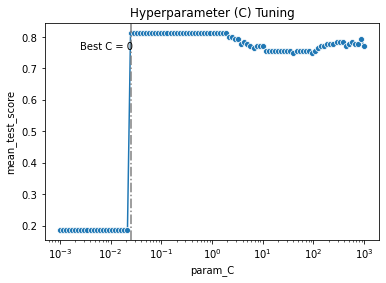

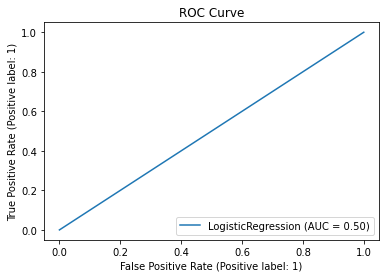

In [ ]:
best_model, best_params, accuracy, auc = train_test_evaluate(X_train, y_train, X_test, y_test)

In [ ]:
print("%s MODEL RESULTS %s" % (">>>" * 3, "<<<" * 3))
print("\tBest Model:", best_model)
print("\tBest Parameters:", best_params)
print("\t"+"---"*8)
print(f"\tMean Baseline: {np.mean(y) * 100:.4f}%")
print(f"\tAccuracy: {accuracy:.4f}")
print(f"\tAUC: {auc:.4f}")


>>>>>>>>> MODEL RESULTS <<<<<<<<<
	Best Model: LogisticRegression(C=0.024770763559917114, penalty='l1', solver='liblinear')
	Best Parameters: {'C': 0.024770763559917114}
	------------------------
	Mean Baseline: 82.9545%
	Accuracy: 0.8889
	AUC: 0.5000
